### [0] Introduction:
This is a practice exercise using TensorFlow to solve an ordinary least squares regression (OLS) via. a trivial neural network (feedfoward with no hidden layers). The purpose here is to gain familiarity with TensorFlow's computational graph framework. We will follow an artificially generated toy example and compare results from the neural network to those of scikit-learn's "out-of-the-box" `LinearRegression` model.

### [1] Data Generation:
We begin by generating random sample ($n=500$) of data following the linear relationship 

$$y = \beta_0 + \beta_1x  + \epsilon,$$ 

with arbitrarily selected parameters $\beta_0 = 10, \beta_1 = 2$ and $\epsilon \sim  \mathcal{N}(0,10^2)$. Moreover, we set the domain of the dependent variable to be $\mathbb{N} \cap [1,100]$ for simplicity. This dataset is what will be used to train both the `sklearn` and `tensorflow` models.

In [1]:
import numpy as np

np.random.seed(888)

n = 500
x = np.random.randint(1,100, n)
y = 10 + 2*x + 10*np.random.randn(n)

# reshape and set precision for modelling
x = x.reshape(n, 1).astype(np.float64)
y = y.reshape(n, 1).astype(np.float64)

### [2] `sklearn` Model:
Scikit-learn has a very concise and straightforward implementation of the OLS regression. From the results, we notice that the predicted values of $\beta_0$ differs from the original distribution. Although this discrepency ostensibly seems significant, plotting the line of best fit atop the toy data reveals a very reasonable fit.

beta_0: 11.826724863127168
beta_1: 1.982784526230367


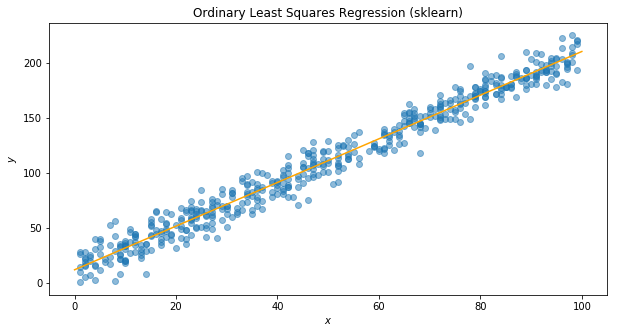

In [252]:
import sklearn as sk
import matplotlib.pyplot as plt

# fit sk linear regression 
reg    = sk.linear_model.LinearRegression().fit(x, y)
beta_1 = reg.coef_
beta_0 = reg.intercept_

# line of best fit 
z = np.linspace(0, 100, 2)
w = beta_1[0]*z + beta_0[0]

# plot 
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(x, y, alpha=0.5)
ax.plot(z, w, color="orange")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Ordinary Least Squares Regression (sklearn)")

print("beta_0: {}".format(beta_0[0]))
print("beta_1: {}".format(beta_1[0][0]))

### [3] `tensorflow` Model:
Before implementing the neural net model to our linear regression problem, we first outline the steps using vanilla Numpy; doing so will serve as a guide to crafting the TensorFlow computational graph as well as a sanity benchmark to which we can compare our results:

In [137]:
training_steps = 50000
learning_rate  = 0.000001

weights = []
losses = []

# default params
bias_with_x = np.array([(1., i) for i in x])
target      = y.astype(np.float64)
weight      = np.array([0, 0]).reshape(2,1).astype(np.float64)

for i in range(training_steps):
    # update params
    y_hat  = np.matmul(bias_with_x, weight)
    y_err  = target - y_hat
    grad   = np.matmul(bias_with_x.T,  y_err)
    
    weights.append(weight.flatten())
    losses.append(np.sum(np.abs(y_err)))
    
    weight = weight + learning_rate*grad
    
print("weight_0: {}".format(weight[0][0]))
print("weight_1: {}".format(weight[1][0]))

weight_0: 11.8080133732
weight_1: 1.98306584579


Comparing our results with scikit-learn, we see essentially identical model weights. To get a sense of how the neural net is learning, we plot the weights in $\mathbb{R}^2$ as well as the error as a function of time (learning steps). From these two plots, it becomes clear that the majority of learning is completed within the first 10,000 steps and the remainder is simply refining the $w_0$ prediction.

Note: The choice of step size was determined from trial and error. Larger step sizes will not converge due to the very large gradient values that arise (resulting in succesively more massive steps, diverging to $\infty$) Perhaps normalization of the $x$ and $y$ values or even the gradient itself, may mitigate this divergence effect.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


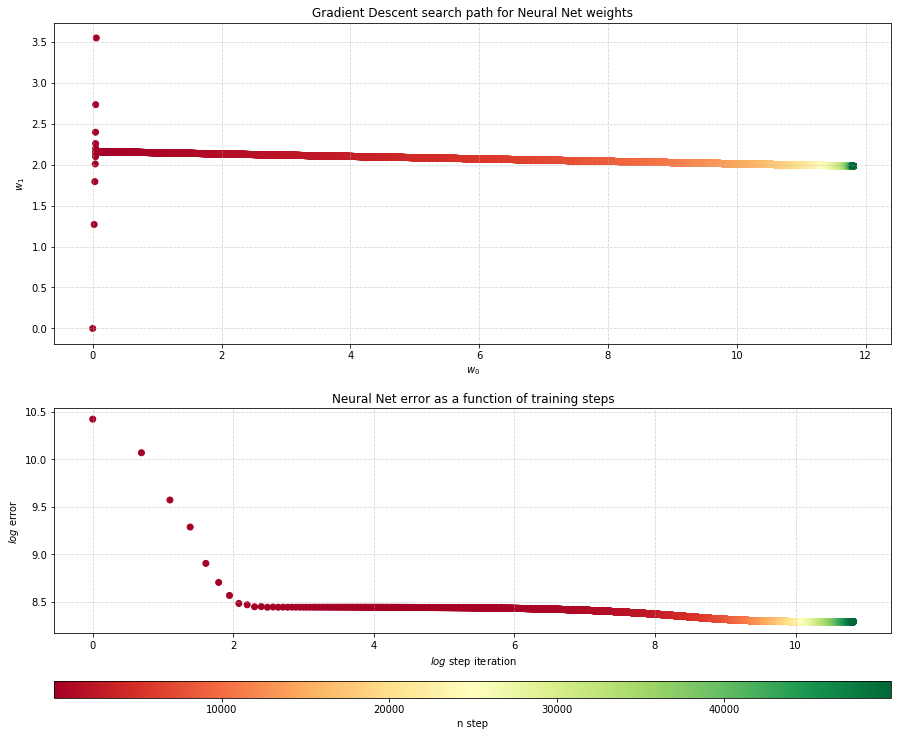

In [138]:
import matplotlib.pyplot as plt

step = range(training_steps)
w_0  = [i[0] for i in weights]
w_1  = [i[1] for i in weights]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 13))

# first axes
sctr = ax1.scatter(x = w_0, y = w_1, c = step, cmap = "RdYlGn")
ax1.grid(linestyle='--', alpha = 0.5)
ax1.set_xlabel("$w_0$")
ax1.set_ylabel("$w_1$")
ax1.set_title("Gradient Descent search path for Neural Net weights")

# second axes 
sctr = ax2.scatter(x = np.log(step), y = np.log(losses), c = step, cmap = "RdYlGn")
ax2.grid(linestyle = '--', alpha = 0.5)
ax2.set_xlabel("$log$ step iteration")
ax2.set_ylabel("$log$ error")
ax2.set_title("Neural Net error as a function of training steps")

# colorbar
plt.colorbar(sctr, ax = ax2, orientation = 'horizontal',  label = "n step", aspect = 50)

Now, we replicate the logic of the previous `numpy` model using the `tensorflow` framework:

In [139]:
import tensorflow as tf
    
with tf.Session() as sess:
    
    # static training params 
    training_steps = 50000
    learning_rate  = 0.000001
    bias_with_x    = np.array([(1., i) for i in x]) # OLS bias matrix 
    default_weight = np.array([0, 0]).reshape(2,1).astype(np.float64)
    
    # static consts and dynamic vars
    input  = tf.constant(bias_with_x)
    target = tf.constant(y)
    weight = tf.Variable(default_weight)
    
    # initialize vars
    tf.global_variables_initializer().run()
    
    # operations 
    y_hat       = tf.matmul(input, weight)
    y_err       = tf.subtract(target, y_hat)
    grad        = tf.matmul(input, y_err, transpose_a = True)
    updt_weight = tf.assign_add(weight, learning_rate*grad)

    for i in range(training_steps):
        sess.run(updt_weight)
    
    print("weight_0: {}".format(weight.eval()[0][0]))
    print("weight_1: {}".format(weight.eval()[1][0]))

weight_0: 11.8080133732
weight_1: 1.98306584579
